This script runs spatial autocorrelation correction based on the basecalss of the brainsmash toolbox. 
We decided to habe the structural connectivity gradients as stable variable and rotate (build surrogates of) the map we want to correlate our gradients with (qT1, core-matrix, functional gradients). 
Therefore, we use the same surrogates for correlation with Gradient 1 and Gradient 2 and makes it possible to compare between both. 

In [1]:
#import modules
import numpy as np
import nibabel as nb
import brainsmash
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

/data/u_ajohn_software/anaconda3/envs/brainsmash/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### define properties

In [2]:
#CHANGE!!! #define left or right hemisphere to load in the correct files
hemisphere="right"
if hemisphere=="left":
    hem="left"
    xh ="lh"
elif hemisphere == "right":
    hem="right"
    xh ="rh"

#CHANGE!!! #define map you want to correlate gradients with
#map_to_rotate=nb.load("/data/p_02666/Project1_thalamus/Atlas/CoreMatrix/calb_minus_pvalb.nii").get_fdata()
#map_to_rotate=nb.load("/data/p_02666/Project1_thalamus/structural_covariance/grouplevel_T1q_map_{}.nii.gz".format(xh)).get_fdata()
#map_to_rotate = nb.load("/data/p_02666/Project1_thalamus/functional_connectivity/gradient1_{}_tha.nii.gz".format(hem)).get_fdata()
map_to_rotate = nb.load("/data/p_02666/Project1_thalamus/functional_connectivity/gradient2_{}_tha.nii.gz".format(hem)).get_fdata()

#CHANGE!!! #define a map_name to save results
map_name="funcgradient2"   #"core_matrix" "qT1","funcgradient1", "funcgradient2"

#change!!!
rotation = "exists" # "create" or "exists" to either create surrogates or load them in

#ChANGE!!! where to save the results
save_to="/data/p_02666/Project1_thalamus/SA_variogramms/"
path_map_txt= save_to+ "vector_{}.txt".format(map_name)


In [3]:
#thalamus mask
thala_ref=nb.load("/data/p_02666/mica-mics/thalamus_space_mni/space-MNI125_atlas-thalamus_{}_refined.nii.gz".format(xh)).get_fdata()
idx=np.where(thala_ref==1)   #indeces of thalamus volume

#struc conn gradients
gradient1=nb.load("/data/p_02666/Project1_thalamus/structural_connectivity/parcels_200/gradient1_{}_tha.nii.gz".format(hem)).get_fdata()
gradient2=nb.load("/data/p_02666/Project1_thalamus/structural_connectivity/parcels_200/gradient2_{}_tha.nii.gz".format(hem)).get_fdata()
g1=gradient1[idx] #vector of g1 values
g2=gradient2[idx] #vector of g2 values

#check if map and gradients have same shape, if not (i.e. core_matrix_map) build intersection
if np.where(map_to_rotate[idx]!=0)[0].shape != np.where(thala_ref[idx]!=0)[0].shape:
    print("unequal size of map to rotate and gradient map, calculate intersect")
    #create intersect of gene expression map and thalamic mask
    thala_ref[map_to_rotate==0]=0   #create intersect between orig thala mask and cp map
    gradient1[thala_ref==0]=0   #mask out gradient1 nifti with new reference mask  ->799 voxel
    gradient2[thala_ref==0]=0   #mask out gradient1 nifti with new reference mask  ->799 voxel
    
    #create distance matrix of intersection
    idx=np.where(thala_ref==1)
    indices=np.zeros((len(idx[0]),3))
    indices[:,0]=idx[0]
    indices[:,1]=idx[1]
    indices[:,2]=idx[2]

    diff=indices[:, :, np.newaxis] - indices[:, :, np.newaxis].T
    dist_mat_fin=np.linalg.norm(diff, axis=1)
    #np.savetxt(save_to+"distance_matrix_{}_core_matrix.txt".format(hem),dist_mat, delimiter=' ')
    g1=gradient1[idx] #vector of g1 values
    g2=gradient2[idx] #vector of g2 values
    
    #save intersection of map_to_rotate as txt file
    vector_map_to_rotate=map_to_rotate[idx]
    np.savetxt(path_map_txt ,vector_map_to_rotate, delimiter=' ')
    
elif np.where(map_to_rotate[idx]!=0)[0].shape == np.where(thala_ref[idx]!=0)[0].shape:
    print("equal size of map to rotate and gradient map")
    # if distance matrix is already created load, if not run euclidian distance calculation
    dist_mat_fin = save_to+"distance_matrix_{}.txt".format(hem)  # input text file
    vector_map_to_rotate=map_to_rotate[idx]
    np.savetxt(path_map_txt ,vector_map_to_rotate, delimiter=' ')

equal size of map to rotate and gradient map


### Load in files 

### euclidian distance matrix 
!!!!only for maps where size of map fits size of thalamus ref (so not for the core_matrix)
-> run only once 

In [249]:
if map_name!="core_matrix": 
    #create the euclidian distance matrix between thalamic voxel
    thala_ref=nb.load("/data/p_02666/mica-mics/thalamus_space_mni/space-MNI125_atlas-thalamus_{}_refined.nii.gz".format(xh)).get_fdata()
    idx=np.where(thala_ref==1)   #indeces of thalamus volume
    n=idx[0].shape  #number of voxels of mask
    indices=np.zeros((n[0],3)) 
    indices[:,0]=idx[0]
    indices[:,1]=idx[1]
    indices[:,2]=idx[2]

    diff=indices[:, :, np.newaxis] - indices[:, :, np.newaxis].T
    dist_mat=np.linalg.norm(diff, axis=1)

    #save as txt
    np.savetxt(save_to+"distance_matrix_{}.txt".format(hem),dist_mat, delimiter=' ')

### check fit of surrogates

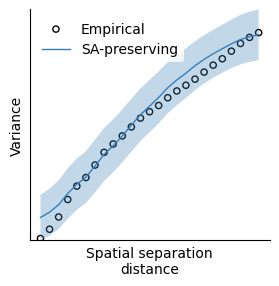

In [306]:
from brainsmash.mapgen.eval import base_fit
#read txt file of map that has to be rotated 
brain_map_file = path_map_txt 

kwargs = {
          'pv': 60
          }

brain_map_file = path_map_txt 
base_fit(brain_map_file, dist_mat_fin, nsurr=100,**kwargs)

#If you are unhappy with the fit, it is recommended that you try varying the three 
#parameters included in the keyword argument dictionary above (i.e., ns, knn, and pv).
#knn and ns are only paramter relevant for sampled fit class
#only parameter that can be changed is pv:
#but does not affect the fit
#geht auch mehr um steigung?


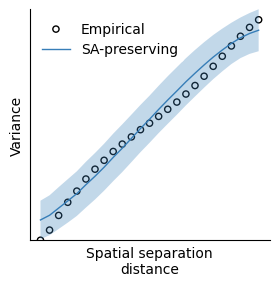

In [307]:
from brainsmash.mapgen.eval import base_fit
#read txt file of map that has to be rotated 
brain_map_file = path_map_txt 

kwargs = {
          'pv': 80
          }

brain_map_file = path_map_txt 
base_fit(brain_map_file, dist_mat_fin, nsurr=100,**kwargs)

#If you are unhappy with the fit, it is recommended that you try varying the three 
#parameters included in the keyword argument dictionary above (i.e., ns, knn, and pv).
#knn and ns are only paramter relevant for sampled fit class
#only parameter that can be changed is pv:
#but does not affect the fit
#geht auch mehr um steigung?

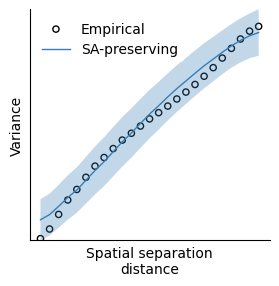

In [308]:
from brainsmash.mapgen.eval import base_fit
#read txt file of map that has to be rotated 
brain_map_file = path_map_txt 

kwargs = {
          'pv': 75
          }

brain_map_file = path_map_txt 
base_fit(brain_map_file, dist_mat_fin, nsurr=100,**kwargs)

#If you are unhappy with the fit, it is recommended that you try varying the three 
#parameters included in the keyword argument dictionary above (i.e., ns, knn, and pv).
#knn and ns are only paramter relevant for sampled fit class
#only parameter that can be changed is pv:
#but does not affect the fit
#geht auch mehr um steigung?

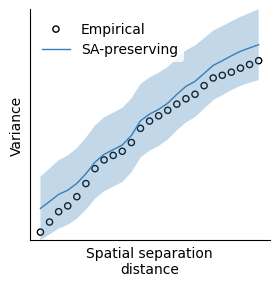

In [309]:
from brainsmash.mapgen.eval import base_fit
#read txt file of map that has to be rotated 
brain_map_file = path_map_txt 

kwargs = {
          'pv':25,
          }

brain_map_file = path_map_txt 
base_fit(brain_map_file, dist_mat_fin, nsurr=100,**kwargs)

## create surrogate maps of map_to_rotate

In [4]:
pv=25

if rotation == "create":
    print("create surrogates")
    #read txt file of map that has to be rotated 
    brain_map_file = path_map_txt 
    kwargs = {'pv': pv  } 
    #create instance of base class
    base = Base(x=brain_map_file, D=dist_mat_fin, **kwargs)
    #create surrogate maps
    surrogates = base(n=1000)
    #save surrogate maps
    np.save(save_to+"surrogates_{}_{}_pv{}.npy".format(map_name,hem,pv),surrogates)
elif rotation == "exists":
    print("load surrogates")
    surrogates=np.load(save_to+"surrogates_{}_{}_pv{}.npy".format(map_name,hem,pv))

load surrogates


### compute pearson correlation between each surrogate map and the gradients

In [5]:
#!!!!CHANGE BOTH
gradient=g2
grad="g2"

In [6]:
surrogate_brainmap_corrs = pearsonr(gradient, surrogates).flatten()
surrogate_pairwise_corrs = pairwise_r(surrogates, flatten=True)

### repeat using randomly shuffled surrogate maps 

In [7]:
naive_surrogates = np.array([np.random.permutation(vector_map_to_rotate) for _ in range(1000)])
naive_brainmap_corrs = pearsonr(gradient, naive_surrogates).flatten()
naive_pairwise_corrs = pairwise_r(naive_surrogates, flatten=True)

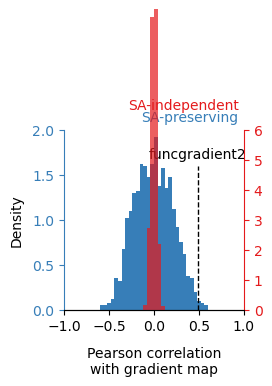

In [8]:


sac = '#377eb8'  # autocorr-preserving
rc = '#e41a1c'  # randomly shuffled
bins = np.linspace(-1, 1, 51)  # correlation b

# this is the empirical statistic we're creating a null distribution for
test_stat = stats.pearsonr(vector_map_to_rotate, gradient)[0]

fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0.2, 0.25, 0.6, 0.6])  # autocorr preserving
ax2 = ax.twinx()  # randomly shuffled

# plot the data
ax.axvline(test_stat, 0, 0.8, color='k', linestyle='dashed', lw=1)
ax.hist(surrogate_brainmap_corrs, bins=bins, color=sac, alpha=1,
    density=True, clip_on=False, zorder=1)
ax2.hist(naive_brainmap_corrs, bins=bins, color=rc, alpha=0.7,
    density=True, clip_on=False, zorder=2)

# make the plot nice...
ax.set_xticks(np.arange(-1, 1.1, 0.5))
ax.spines['left'].set_color(sac)
ax.tick_params(axis='y', colors=sac)
ax2.spines['right'].set_color(rc)
ax2.tick_params(axis='y', colors=rc)
ax.set_ylim(0, 2)
ax2.set_ylim(0, 6)
ax.set_xlim(-1, 1)
[s.set_visible(False) for s in [
    ax.spines['top'], ax.spines['right'], ax2.spines['top'], ax2.spines['left']]]
ax.text(0.97, 1.1, 'SA-independent', ha='right',va='bottom',
    color=rc, transform=ax.transAxes)
ax.text(0.97, 1.03, 'SA-preserving', ha='right', va='bottom',
    color=sac, transform=ax.transAxes)
ax.text(test_stat, 1.65, map_name, ha='center', va='bottom')
ax.text(0.5, -0.2, "Pearson correlation\nwith gradient map",
    ha='center', va='top', transform=ax.transAxes)
ax.text(-0.3, 0.5, "Density", rotation=90, ha='left', va='center', transform=ax.transAxes)
plt.show()

In [10]:
#### P values
from brainsmash.mapgen.stats import nonparp
print(map_name)
print(hemisphere)
print("Pearson r:",test_stat)
print("Spatially naive p-value:", format(nonparp(test_stat, naive_brainmap_corrs), '.50f'))
print("SA-corrected p-value:", format(nonparp(test_stat, surrogate_brainmap_corrs), '.50f'))

funcgradient2
right
Pearson r: 0.4839833024930986
Spatially naive p-value: 0.00000000000000000000000000000000000000000000000000
SA-corrected p-value: 0.01600000000000000033306690738754696212708950042725


In [338]:
#save results
import csv

# Open a CSV file for writing
file_path = save_to + "output_rotated_{}_{}_{}.csv".format(map_name,grad,hem)
with open(file_path, "w", newline="") as file:
    writer = csv.writer(file)

    # Write header row
    writer.writerow(["Variable Name", "Value"])

    # Write variable data
    writer.writerow(["map_rotated", map_name])
    writer.writerow(["gradient", grad])
    writer.writerow(["hemisphere", hem])
    writer.writerow(["pv", pv])
    writer.writerow(["Pearson r:", test_stat])
    writer.writerow(["Spatially naive p-value:", format(nonparp(test_stat, naive_brainmap_corrs), '.50f')])
    writer.writerow(["SA-corrected p-value:", format(nonparp(test_stat, surrogate_brainmap_corrs), '.50f')])
    
    

print("Variables written to the CSV file successfully.")


Variables written to the CSV file successfully.
